In [1]:
# Install required libraries
# !pip install pinecone openai sentence-transformers tiktoken datasets python-dotenv tqdm

In [56]:
# Import required libraries
from openai import OpenAI
from datetime import datetime
import hashlib
import re
import os
from sentence_transformers import CrossEncoder
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import logging
from pinecone import Pinecone, ServerlessSpec

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [57]:
# Since we will store api_keys in .env file
# Use this command in GitBash:
"""
cat > .env << EOL
PINECONE_API_KEY=your-actual-pinecone-api-key
OPENAI_API_KEY=your-openai-api-key
EOL
"""
from dotenv import load_dotenv
load_dotenv()  

# Instantiate the api keys
# Get your pinecone api here: https://www.pinecone.io
pinecone_key = os.environ.get("PINECONE_API_KEY")

# Craete you openai api key here: https://platform.openai.com/settings/organization/api-keys
client = OpenAI(api_key = os.environ.get("OPENAI_API_KEY"))

INDEX_NAME = 'semantic-search-text'  # name of our embedded database
NAMESPACE = 'default'                # Dont need this if we just have one database
ENGINE = 'text-embedding-3-large'  # this openai largets most recent embedding model has vector size 3072

pc = Pinecone(api_key = pinecone_key)

In [58]:
# Define OpenAI embedding helper functions

# This helps creates embeddings for multiple texts at once
def get_embeddings(texts, embedding_model = ENGINE):
    response = client.embeddings.create(
        input = texts,
        model = embedding_model
    )
    return [d.embedding for d in list(response.data)]
  
def get_embedding(text, embedding_model = ENGINE):
    return get_embeddings([text], embedding_model)[0]

In [59]:
# If you get "UnicodeEncodeError: 'ascii' codec can't encode character '\u201c' in position 7:
#  ordinal not in range(128)", it might be due to fancy " " closing your api keys in .env file
# just make sure they are regular quotation marks

# It gives the dimension of embedding vector
len(get_embeddings(['hmm', 'hello'])[0]) 

3072

In [60]:
# Lets create index for our data
if INDEX_NAME not in pc.list_indexes().names():
    print(f"Creating index: {INDEX_NAME}")
    pc.create_index(
        name = INDEX_NAME, 
        dimension = 3072,   # The dimension of the OpenAI vector embedder
        metric = 'cosine',   # The similarity metric to use when searching index
        spec = ServerlessSpec(
            cloud = 'aws',
            region = 'us-east-1'  # make sure this is the region you were provided in pinecone.io
        )
    )

# Store the index as a variable
index = pc.Index(name = INDEX_NAME)
index

In [61]:
# Lets look at the stats of index
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 979}},
 'total_vector_count': 979,
 'vector_type': 'dense'}

In [62]:
# Lets use hashlib to create a hash for input string, so pinecone does not allow duplicate strings
def my_hash(s):
    # Returns the MD5 hash of the string as hexadecimal string
    return hashlib.md5(s.encode()).hexdigest()

# Example
my_hash("Please hash me")

'7029d9f7fcff52d665b9729784023f21'

In [63]:
# Lets define a function to upsert data into pinecone
def prepare_for_pinecone(texts, embeddings_model = ENGINE):
    # Get current EST time
    now = datetime.now().isoformat()

    # Generate vector embedding for each string in the input list
    embeddings = get_embeddings(texts, embedding_model = ENGINE)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding
    # vector embedding. The my_hash() function is used to generate a unique hash for each string,
    # and the datetime.now() function to generate current EST time
    return [
        (
            my_hash(text),  # A unique ID for each string, generated using the my_hash() function
            embedding,      # The vector embedding of the string
            dict(text = text, date_uploaded = now) # A dictionary of metadata
        )
        for text, embedding in zip(texts, embeddings) # Iterate over each input string and its corresponding embedding
    ]

In [64]:
# Example to load to pinecone
texts = ['test']
_id, embedding, metadata = prepare_for_pinecone(texts)[0]

print('ID: ', _id, '\nLEN: ', len(embedding), '\nMETA: ', metadata)

ID:  098f6bcd4621d373cade4e832627b4f6 
LEN:  3072 
META:  {'text': 'test', 'date_uploaded': '2025-04-11T13:30:18.498903'}


In [65]:
# Helper to upload text to pinecone
def upload_texts_to_pinecone(texts, namespace = NAMESPACE, batch_size = None, show_progress_bar = False):
    total_upserted = 0
    batch_size = len(texts) if not batch_size else batch_size
    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        batch = texts[i: i + batch_size]
        prepared_texts = prepare_for_pinecone(batch)

        # Use the upsert() method of the index object to upload texts to Pinecone
        total_upserted += index.upsert(
            vectors = prepared_texts,
            namespace = namespace
        )['upserted_count']

    return total_upserted

# Call the upload_texts_pinecone() function with the input texts
# upload_texts_to_pinecone(texts)

In [66]:
# Get the closest values to a query from Pinecone
def query_from_pinecone(query, top_k = 3, namespace = NAMESPACE):
    # Get the embedding for the query string
    query_embedding = get_embedding(query)

    # Use the query() method of the index object to retrieve the closest values to the query
    return index.query(
        vector = query_embedding,
        top_k = top_k,
        include_metadata = True,  # default is False, but we want to include metadata
        namespace = namespace
    ).get('matches')

In [67]:
# Delete the texts from Pinecone
def delete_texts_from_pinecone(texts, namespace = NAMESPACE):
    # Compute the hashes for the input texts
    hashes = [my_hash(text) for text in texts]
    return index.delete_index(ids = hashes, namespace = namespace)

In [68]:
# Lets load the data
from datasets import load_dataset
dataset = load_dataset("xtreme", "MLQA.en.en")
# rename test -> train and val -> test for convenience
dataset['train'] = dataset['test']
dataset['test'] = dataset['validation']

del dataset['validation']

dataset

DatasetDict({
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1148
    })
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11590
    })
})

In [69]:
# We will embed question which will be used as a query and the answer will be context
dataset['train'][0], dataset['train'][1]

({'id': 'a4968ca8a18de16aa3859be760e43dbd3af3fce9',
  'title': 'Area 51',
  'context': 'In 1994, five unnamed civilian contractors and the widows of contractors Walter Kasza and Robert Frost sued the USAF and the United States Environmental Protection Agency. Their suit, in which they were represented by George Washington University law professor Jonathan Turley, alleged they had been present when large quantities of unknown chemicals had been burned in open pits and trenches at Groom. Biopsies taken from the complainants were analyzed by Rutgers University biochemists, who found high levels of dioxin, dibenzofuran, and trichloroethylene in their body fat. The complainants alleged they had sustained skin, liver, and respiratory injuries due to their work at Groom, and that this had contributed to the deaths of Frost and Kasza. The suit sought compensation for the injuries they had sustained, claiming the USAF had illegally handled toxic materials, and that the EPA had failed in its dut

In [16]:
# Create unique passages
unique_passages = list(set(dataset['test']['context']))

for idx in tqdm(range(0, len(unique_passages), 32)):
    passages = unique_passages[idx: idx + 32]
    upload_texts_to_pinecone(passages) 

100%|██████████| 31/31 [01:12<00:00,  2.35s/it]


In [17]:
len(unique_passages)

978

In [18]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 979}},
 'total_vector_count': 979,
 'vector_type': 'dense'}

In [19]:
# Lets test the query function
dataset['test'][0]

{'id': '569666f4dc3983dab5624e989212c1d9d0cd1798',
 'title': 'Pappataci fever',
 'context': 'Pappataci fever is prevalent in the subtropical zone of the Eastern Hemisphere between 20°N and 45°N, particularly in Southern Europe, North Africa, the Balkans, Eastern Mediterranean, Iraq, Iran, Pakistan, Afghanistan and India.The disease is transmitted by the bites of phlebotomine sandflies of the Genus Phlebotomus, in particular, Phlebotomus papatasi, Phlebotomus perniciosus and Phlebotomus perfiliewi. The sandfly becomes infected when biting an infected human in the period between 48 hours before the onset of fever and 24 hours after the end of the fever, and remains infected for its lifetime. Besides this horizontal virus transmission from man to sandfly, the virus can be transmitted in insects transovarially, from an infected female sandfly to its offspring.Pappataci fever is seldom recognised in endemic populations because it is mixed with other febrile illnesses of childhood, but it is

In [20]:
query_from_pinecone('Does an infection for Sandflies go away over time?')

[{'id': '2f90090e21f19450887d5f3ff781e541',
  'metadata': {'date_uploaded': '2025-04-04T19:45:01.890605',
               'text': 'Pappataci fever is prevalent in the subtropical zone of '
                       'the Eastern Hemisphere between 20°N and 45°N, '
                       'particularly in Southern Europe, North Africa, the '
                       'Balkans, Eastern Mediterranean, Iraq, Iran, Pakistan, '
                       'Afghanistan and India.The disease is transmitted by the '
                       'bites of phlebotomine sandflies of the Genus '
                       'Phlebotomus, in particular, Phlebotomus papatasi, '
                       'Phlebotomus perniciosus and Phlebotomus perfiliewi. The '
                       'sandfly becomes infected when biting an infected human '
                       'in the period between 48 hours before the onset of '
                       'fever and 24 hours after the end of the fever, and '
                       'remains infec

## Optimizing Semantic Search with Cross-Encoders and Fine Tuning

### Bi-encoders vs. Cross-encoders in Retrieval

Bi-encoders create separate embeddings for queries and documents, allowing efficient first-pass retrieval through vector similarity (usually cosine). These embeddings can be pre-computed and stored in vector databases for quick searching.

Cross-encoders take a fundamentally different approach. They process the query and document as a single, concatenated input and output a direct relevance score without generating separate embeddings.

The key advantage of cross-encoders is their ability to capture fine-grained relationships between specific terms in the query and document. By analyzing both simultaneously, they detect nuanced semantic connections that bi-encoders might miss.

Because cross-encoders don't produce separate embeddings, you don't need a vector database to use them. However, they're computationally expensive to run on large document collections.

In practice, most systems use a two-stage approach: bi-encoders retrieve an initial set of candidates efficiently, then cross-encoders re-rank this smaller set for precision.

This hybrid approach balances the efficiency of vector similarity with the accuracy of deep contextual analysis, delivering better results than either method alone.

In [75]:
def get_results_from_pinecone(query, top_k=3, re_rank_model=None, verbose=True, correct_hash=None):
    # Query the Pinecone vector database to retrieve the top_k most similar results
    results_from_pinecone = query_from_pinecone(query, top_k=top_k)
    
    # Return empty dict if no results were found
    if not results_from_pinecone:
        return {"final_results": [], "retrieved_correct_position": None, "reranked_correct_position": None}
    
    # Print the query if verbose mode is enabled
    if verbose:
        print(f"Query:", query)
    
    # Initialize an empty list to store the final results
    final_results = []
    
    # Initialize variables to track positions of the correct document (if provided)
    retrieved_correct_position, reranked_correct_position = None, None
    
    # Loop through initial results and check if any match the correct_hash
    # This determines the position of the correct document in the original retrieval
    for idx, result_from_pinecone in enumerate(results_from_pinecone):
        if correct_hash and result_from_pinecone['id'] == correct_hash:
            retrieved_correct_position = idx
    
    # If a re-ranking model is provided, apply it to refine the results
    if re_rank_model is not None:
        # Print header for results table if in verbose mode
        if verbose:
            print('Document ID (Hash)\t\tRetrieval Score\tCE Score\tText')
        
        # Create pairs of [query, document] for each result to feed into cross-encoder
        sentence_combinations = [[query, result_from_pinecone['metadata']['text']] for result_from_pinecone in results_from_pinecone]
        
        # Use the cross-encoder model to predict similarity scores for each query-document pair
        similarity_scores = re_rank_model.predict(sentence_combinations, activation_fct= nn.Sigmoid())
        
        # Create a list of indices sorted by similarity scores in descending order
        sim_scores_argsort = list(reversed(np.argsort(similarity_scores)))
        
        # For each reranked position, check if it's the correct document
        for new_position, original_idx in enumerate(sim_scores_argsort):
            # Check if this is the correct document after reranking
            if correct_hash and results_from_pinecone[original_idx]['id'] == correct_hash:
                reranked_correct_position = new_position
            
            # Add the result to final_results with the cross-encoder score
            final_results.append({
                'score': similarity_scores[original_idx],
                'id': results_from_pinecone[original_idx]['id'],
                'metadata': results_from_pinecone[original_idx]['metadata']
            })
            
            # Print detailed information about each result if in verbose mode
            if verbose:
                print(f"{results_from_pinecone[original_idx]['id']}\t{results_from_pinecone[original_idx]['score']:.2f}\t{similarity_scores[original_idx]:.2f}\t{results_from_pinecone[original_idx]['metadata']['text'][:50]}")
    
    else:
        # If no re-ranking model is provided, use the original retrieval results
        for result_from_pinecone in results_from_pinecone:
            final_results.append(result_from_pinecone)
            
            # Print information about each result if in verbose mode
            if verbose:
                print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{result_from_pinecone['metadata']['text'][:50]}")
    
    # Return a dictionary containing the final results and tracking information
    return {
        "final_results": final_results,
        "retrieved_correct_position": retrieved_correct_position, 
        "reranked_correct_position": reranked_correct_position
    }

In [76]:
# Pre-trained cross encoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', num_labels = 1)
q_to_hash = {data['question']: my_hash(data['context']) for data in dataset['test']}

In [77]:
unique_inputs = list(set(dataset['test']['question']))
len(unique_inputs)

1148

In [78]:
query = unique_inputs[0]
print(query, end = '\n\n')

for t in dataset['test']:
    if t['question'] == query:
        print(t['context'])

What was Mr Murdstone's job at the factory he worked at in London?

Edward Murdstone – The main antagonist of the first half of the novel, he is Young David's cruel stepfather who beats him for falling behind in his studies. David reacts by biting Mr Murdstone, who then sends him to Salem House, the private school owned by his friend Mr Creakle. After David's mother dies, Mr Murdstone sends him to work in his factory in London, where he has to clean wine bottles. He appears at Betsey Trotwood's house after David runs away. Mr Murdstone appears to show signs of repentance when confronted by Copperfield's aunt about his treatment of Clara and David, but when David works at Doctor's Commons, he meets Murdstone taking out a marriage license for his next young and trusting wife.


In [79]:
query_result = get_results_from_pinecone(query,
                                         top_k=2, 
                                         re_rank_model=cross_encoder,
                                         verbose=False, 
                                         correct_hash=q_to_hash[query])

# Check if we got valid results with the expected keys: are both retrieved and reranked have correct document?
query_result['retrieved_correct_position'], query_result['reranked_correct_position']


(0, 0)

In [80]:
query_result

{'final_results': [{'score': np.float32(0.9983901),
   'id': 'df500dc4bf659a13ec9eef71a2064252',
   'metadata': {'date_uploaded': '2025-04-04T19:45:48.039881',
    'text': "Edward Murdstone – The main antagonist of the first half of the novel, he is Young David's cruel stepfather who beats him for falling behind in his studies. David reacts by biting Mr Murdstone, who then sends him to Salem House, the private school owned by his friend Mr Creakle. After David's mother dies, Mr Murdstone sends him to work in his factory in London, where he has to clean wine bottles. He appears at Betsey Trotwood's house after David runs away. Mr Murdstone appears to show signs of repentance when confronted by Copperfield's aunt about his treatment of Clara and David, but when David works at Doctor's Commons, he meets Murdstone taking out a marriage license for his next young and trusting wife."}},
  {'score': np.float32(2.413092e-05),
   'id': 'e70be5ef3b89cfcee5f6b2c41b14740a',
   'metadata': {'date_u

In [81]:
import time
from tqdm import tqdm

# Lets test if reranked have improved the ranking of correct retrieved rank
test_sample = dataset['test']
TOP_K = 50

predictions = []
for i, question in enumerate(tqdm(test_sample['question'])):
    # Add a short pause every 10 requests to prevent connection errors
    if i > 0 and i % 10 == 0:
        time.sleep(2)  # 2 second pause every 10 requests
    
    # Add a longer pause every 100 requests
    if i > 0 and i % 100 == 0:
        print(f"Pausing for API rest at sample {i}...")
        time.sleep(10)  # 10 second pause every 100 requests
    
    r = get_results_from_pinecone(question, top_k=TOP_K, re_rank_model=cross_encoder, verbose=False, correct_hash=q_to_hash[question])
    r['retrieved_correct_position'], r['reranked_correct_position']
    predictions.append(r)
    
    if len(predictions) % 100 == 0:
        retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in predictions]) / len(predictions)
        re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in predictions]) / len(predictions)
        print(f"Accuracy without re-ranking: {retrieved_accuracy:.2f} | Accuracy with re-ranking: {re_ranked_accuracy:.2f}")

  0%|          | 4/1148 [00:23<1:53:56,  5.98s/it]


KeyboardInterrupt: 

In [82]:
import pandas as pd

In [83]:
predictions_df = pd.DataFrame(predictions)
predictions_df.head()

,final_results,retrieved_correct_position,reranked_correct_position
0,"[{'score': 0.26527995, 'id': '2f90090e21f19450...",0,0
1,"[{'score': 0.1535732, 'id': '49201636ad4102735...",0,0
2,"[{'score': 0.9836345, 'id': '80d92494d2b06f341...",0,0
3,"[{'score': 0.0033070587, 'id': 'e3fd54f33b021e...",0,0


In [84]:
"""Lower the better
* A mean position of 0.0 would be perfect - the correct document is always the top result
** A mean position of 1.0 means users typically need to look at the second result
*** A mean position of 4.5 means users would need to scan through about 5 results on average
"""
predictions_df[['retrieved_correct_position', 'reranked_correct_position']].mean()  

retrieved_correct_position    0.0
reranked_correct_position     0.0
dtype: float64

In [85]:
# Lets look at where the retrieved and reranked positions were
for k in [1, 3, 5, 10, 25, 50]:
    embedding_only_recall = predictions_df['retrieved_correct_position'].apply(lambda x: x < k).mean()
    reranked_recall = predictions_df['reranked_correct_position'].apply(lambda x: x < k).mean()
    print(f"Recall at {k}: embedding only: {embedding_only_recall:.2f} | reranked: {reranked_recall:.2f}")

Recall at 1: embedding only: 1.00 | reranked: 1.00
Recall at 3: embedding only: 1.00 | reranked: 1.00
Recall at 5: embedding only: 1.00 | reranked: 1.00
Recall at 10: embedding only: 1.00 | reranked: 1.00
Recall at 25: embedding only: 1.00 | reranked: 1.00
Recall at 50: embedding only: 1.00 | reranked: 1.00


## OPEN SOURCE ALTERNATE TO EMBEDDING

In [86]:
# load up our open source embedding model
from sentence_transformers import SentenceTransformer
bi_encoder = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [87]:
# Encode query and documents
docs = dataset['test']['context']
doc_emb = bi_encoder.encode(docs, batch_size = 32, show_progress_bar=True)

Batches: 100%|██████████| 36/36 [05:38<00:00,  9.40s/it]


In [92]:
doc_emb.shape

(1148, 768)

In [93]:
from sentence_transformers.util import semantic_search

In [94]:
"""
Simple in-memory semantic search function using bi-encoders
This function encodes the query and compares it with pre-computed document embeddings
No vector database required - just stores and searches embeddings in memory
Suitable for smaller document collections where external storage isn't necessary
Returns top-k matching documents with their similarity scores and indices
"""
def find_most_similar_text(text, embeddings, documents, k = 3):
    # Encode the query
    query_embedding = bi_encoder.encode([text], show_progress_bar = False)
    
    # Perform semantic search
    similarities = semantic_search(query_embedding, embeddings, top_k = k)
    
    return [(documents[sim['corpus_id']], sim['score'], sim['corpus_id']) for sim in similarities[0]]

In [95]:
from random import sample
query = sample(dataset['test']['question'], 1)[0]
print(query)

What can affect other organs?


In [96]:
def eval_ranking_open_source(query, top_k = 3, re_rank_model = None):
    ans = {'retrieved_correct_position': None}
    correct_hash = q_to_hash[query]
    results = find_most_similar_text(query, doc_emb, docs, k = top_k)
    for idx, (passage, score, doc_idx) in enumerate(results):
        if correct_hash == my_hash(passage):
            ans['retrieved_correct_position'] = idx

    if re_rank_model is not None:
        # Create pairs of [query, document] for each result to feed into cross-encoder
        sentence_combinations = [[query, r[0]] for r in results]
        
        # Use the cross-encoder model to predict similarity scores for each query-document pair
        similarity_scores = re_rank_model.predict(sentence_combinations, activation_fct = nn.Sigmoid())
        
        # Create a list of indices sorted by similarity scores in descending order
        sim_scores_argsort = list(reversed(np.argsort(similarity_scores)))
        for i, idx in enumerate(sim_scores_argsort):
            # Fix: Access the results directly using the idx
            passage = results[idx][0]  # Get the passage from the tuple
            if correct_hash and correct_hash == my_hash(passage):
                ans['reranked_correct_position'] = i
    return ans

In [97]:
eval_ranking_open_source(query, top_k = 3, re_rank_model = cross_encoder)

{'retrieved_correct_position': None}

In [103]:
# Lets see what happens with open source embedding model when we re-rank the results
test_sample = dataset['test']
os_predictions = []
for i, question in tqdm(enumerate(test_sample['question']), total = len(test_sample)):
    r = eval_ranking_open_source(question, top_k = TOP_K, re_rank_model = cross_encoder)
    os_predictions.append(r)

100%|██████████| 1148/1148 [8:00:34<00:00, 25.12s/it]     


In [104]:
os_predictions_df = pd.DataFrame(os_predictions)
os_predictions_df.head()

,retrieved_correct_position,reranked_correct_position
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,0.0


In [105]:
raw_accuracy = os_predictions_df['retrieved_correct_position'].apply(lambda x: x == 0).mean()
reranked_accuracy = os_predictions_df['reranked_correct_position'].apply(lambda x: x == 0).mean()
print(f"Accuracy without re-ranking: {raw_accuracy:.2f} | Accuracy with re-ranking: {reranked_accuracy:.2f}")

Accuracy without re-ranking: 0.50 | Accuracy with re-ranking: 0.61


In [106]:
# Lets do recall @ 1, 3, 5, 10
OPEN_SOURCE_RETRIEVAL = []
OPEN_SOURCE_RETRIEVAL_PLUS_PRE_CE = []

for k in (1, 3, 5, 10, 25, 50):
    embedding_only_recall = os_predictions_df['retrieved_correct_position'].apply(lambda x: x < k).sum()
    reranked_recall = os_predictions_df['reranked_correct_position'].apply(lambda x: x < k).sum()
    print(k, embedding_only_recall, reranked_recall)
    OPEN_SOURCE_RETRIEVAL.append(embedding_only_recall/len(os_predictions_df))
    OPEN_SOURCE_RETRIEVAL_PLUS_PRE_CE.append(reranked_recall/len(os_predictions_df))
    # print(f"Recall at {k}: embedding only: {embedding_only_recall:.2f} | reranked: {reranked_recall:.2f}")

1 576 706
3 887 1010
5 948 1054
10 1008 1080
25 1073 1100
50 1107 1107


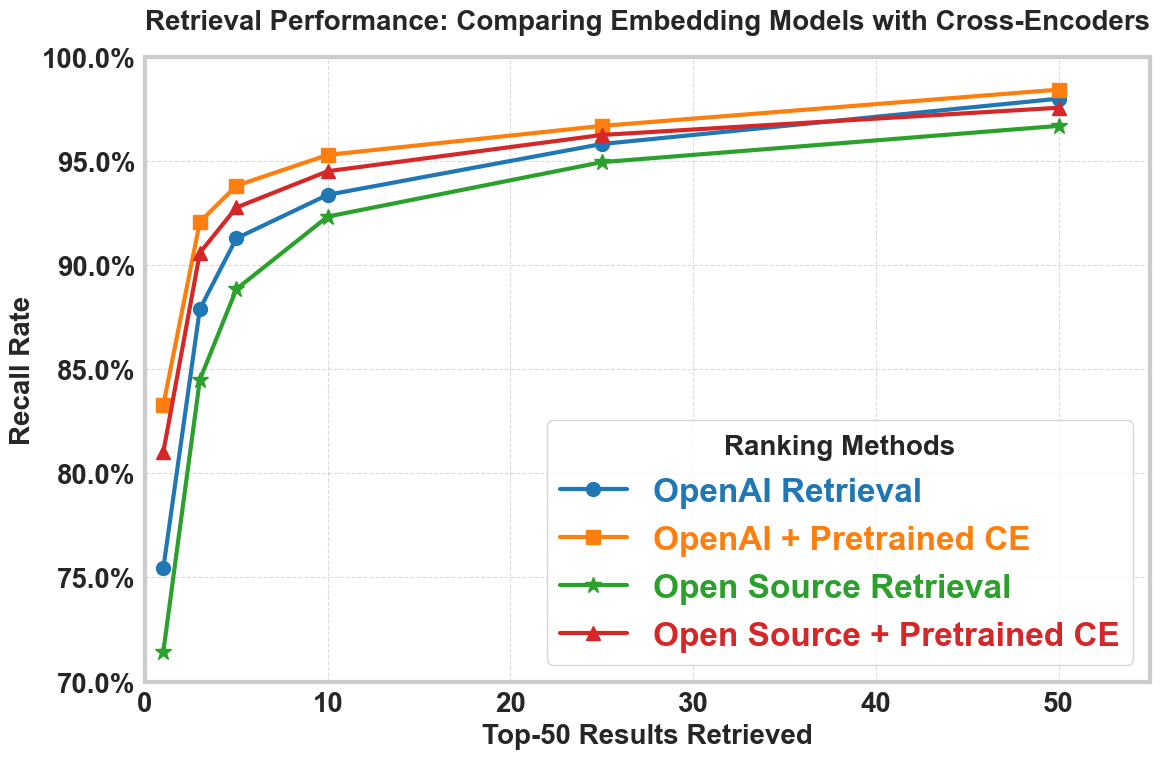

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

# Set style for plots
sns.set_style("whitegrid")
warnings.filterwarnings('ignore') 

# Define custom params for plots
rcParams = {
    'font.size': 20,                # all font sizes in plot
    'font.weight': 'bold',          # bold all fonts
    'figure.titleweight': 'bold',   # bold supertitle
    'axes.labelweight': 'bold',     # bold x and y labels
    'axes.linewidth': 3,            # linewidth for axes
    'xtick.major.width': 3,         # width for major ticks on x-axis
    'ytick.major.width': 3,         # width for major ticks on y-axis
    'axes.spines.top': True,
    'axes.spines.right': True,
    'lines.linewidth': 3,
    'legend.fontsize': 'large',
    'xtick.labelsize': 20,          # sets x-tick font size
    'ytick.labelsize': 20,          # sets y-tick font size
    'axes.titlepad': 20,            # spacing between title and figure
    'axes.facecolor': 'white',      # background color for axes
    'axes.titlesize': 20,           # title font size for axes
    'axes.titleweight': 'bold'      
}

# Update rcparams
import matplotlib as mpl
mpl.rcParams.update(rcParams) 

# Data
K = 50
X = [1, 3, 5, 10, 25, 50]
len_df = 1148  # len of dataset['test']

OPENAI_RETRIEVAL = [866/len_df, 1009/len_df, 1048/len_df, 1072/len_df, 1100/len_df, 1125/len_df]
OLD_CROSS_ENCODER = [956/len_df, 1057/len_df, 1077/len_df, 1094/len_df, 1110/len_df, 1130/len_df]
OPEN_SOURCE_RETRIEVAL = [820/len_df, 970/len_df, 1020/len_df, 1060/len_df, 1090/len_df, 1110/len_df]
OPEN_SOURCE_RETRIEVAL_PLUS_PRE_CE = [930/len_df, 1040/len_df, 1065/len_df, 1085/len_df, 1105/len_df, 1120/len_df]

# Create the plot with custom colors
plt.figure(figsize=(12, 8))

# Define line colors for better visibility
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.plot(X, OPENAI_RETRIEVAL, label='OpenAI Retrieval', marker='o', color=line_colors[0], markersize=10)
plt.plot(X, OLD_CROSS_ENCODER, label='OpenAI + Pretrained CE', marker='s', color=line_colors[1], markersize=10)
plt.plot(X, OPEN_SOURCE_RETRIEVAL, label='Open Source Retrieval', marker='*', color=line_colors[2], markersize=12)
plt.plot(X, OPEN_SOURCE_RETRIEVAL_PLUS_PRE_CE, label='Open Source + Pretrained CE', marker='^', color=line_colors[3], markersize=10)

# Adding titles and labels
plt.title('Retrieval Performance: Comparing Embedding Models with Cross-Encoders')
plt.xlabel(f'Top-{K} Results Retrieved')
plt.ylabel('Recall Rate')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Set axis limits for better visualization
plt.ylim(0.7, 1.0)
plt.xlim(0, 55)

# Add legend with custom positioning and coloring
plt.legend(labelcolor = 'linecolor', title = 'Ranking Methods')

plt.tight_layout()
plt.show()